In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as pjoin
from tqdm import tqdm

import numpy as np
import pandas as pd

from dtaidistance import dtw
import pywt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import torch

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from utils import *
from viz import *

# Hyperparameters

## EDA

In [3]:
PLOT = True

## PREPROCESSING

In [4]:
SMOOTHING_WINDOW = 1 # 1 for no smoothing
DOWNSAMPLE_WINDOW = 1 # 1 for no downsampling

# Get the data

In [5]:
data_folder = pjoin("data", "MixedShapesRegularTrain")
train_fname = "MixedShapesRegularTrain_TRAIN.tsv"
test_fname = "MixedShapesRegularTrain_TEST.tsv"

train_data = pd.read_csv(pjoin(data_folder, train_fname), sep='\t')

# EDA

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Columns: 1025 entries, 1 to 1.1120469
dtypes: float64(1024), int64(1)
memory usage: 3.9 MB


In [7]:
train_data.head()

,1,1.1309687,1.1204832,1.1077719,1.0424568,0.96409116,0.91385703,0.9255513,0.90369937,0.91716544,...,0.67574464,0.66714198,0.75205753,0.82026784,0.8957213,0.9829251,1.0491094,1.0931087,1.1025334,1.1120469
0,1,0.830904,0.815222,0.803198,0.742477,0.683805,0.672666,0.673233,0.679851,0.664352,...,0.545351,0.540754,0.603622,0.650685,0.708652,0.771576,0.791044,0.816584,0.819874,0.823568
1,1,0.816833,0.810941,0.772436,0.734036,0.695747,0.657560,0.617705,0.579676,0.541709,...,0.677791,0.709058,0.710436,0.729174,0.743558,0.785415,0.802844,0.805283,0.807960,0.810870
2,1,1.942775,1.928545,1.903324,1.879062,1.812798,1.746591,1.675465,1.611625,1.548000,...,1.660595,1.701224,1.748952,1.794030,1.845204,1.864267,1.860472,1.909628,1.958690,1.944351
3,1,1.873812,1.863549,1.814253,1.779266,1.766919,1.735888,1.675732,1.699785,1.720428,...,1.818965,1.854731,1.890964,1.918501,1.903307,1.910518,1.895921,1.881597,1.873381,1.898326
4,1,2.314335,2.302548,2.283370,2.246295,2.189444,2.150547,2.092030,2.038564,2.015111,...,1.970946,2.020198,2.072746,2.123032,2.172533,2.219684,2.267653,2.315809,2.317153,2.329100


**Conclusion: the features and the labels can be seperated by the column dtype**

In [8]:
# splitting the dataset to its features and labels
features = train_data.select_dtypes(include=['float64'])
labels = train_data.select_dtypes(include=['int64'])


In [9]:
# get the labels column name
print(labels.columns)

Index(['1'], dtype='object')


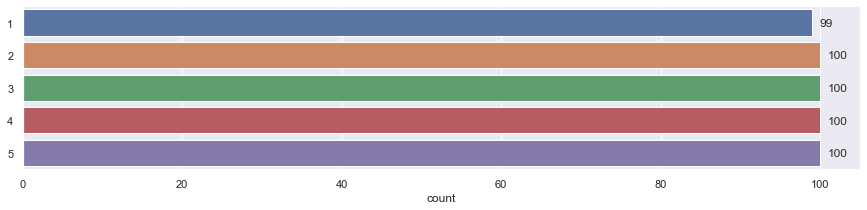

In [10]:
if PLOT:
    # get labels stats
    plt.figure(figsize=(15,3))
    ax = sns.countplot(y="1", data=labels)
    ax.set_ylabel("")
    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', (p.get_width()+1, p.get_y()+0.5))

**Conclusion: balanced dataset**

### Something with the column names doesn't make sense. maybe it should be sorted?

In [11]:
y = features.columns.astype("float")
x = np.arange(len(y))

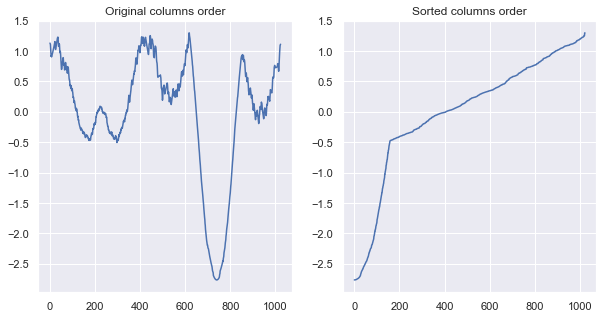

In [12]:
if PLOT:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].plot(x,y)
    axes[1].plot(x,sorted(y))

    axes[0].set_title("Original columns order")
    axes[1].set_title("Sorted columns order")

**Conclusion: Maybe it should be sorted...**

## Visualuziation

In [13]:
NUM_SAMPLES_PER_CLASS = 10

Samples shape: (50, 1024)


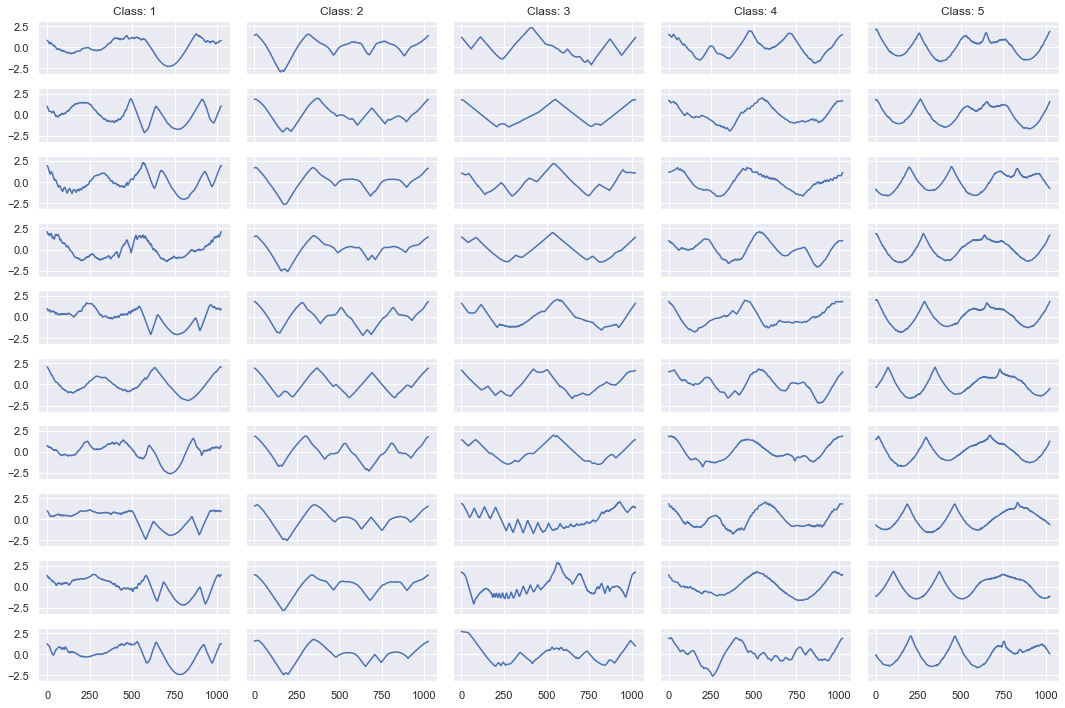

In [14]:
if PLOT:
    samples = visualize_dataset(train_data, NUM_SAMPLES_PER_CLASS)

**Conclusion: looks like a clustering \ knn algorithm will be usefull. I've noticed that some classes (e.g. 1) might have multiple sub-clusters**
**Conclusion: looks like a low pass filtering would be usefull**

Samples shape: (50, 1024)


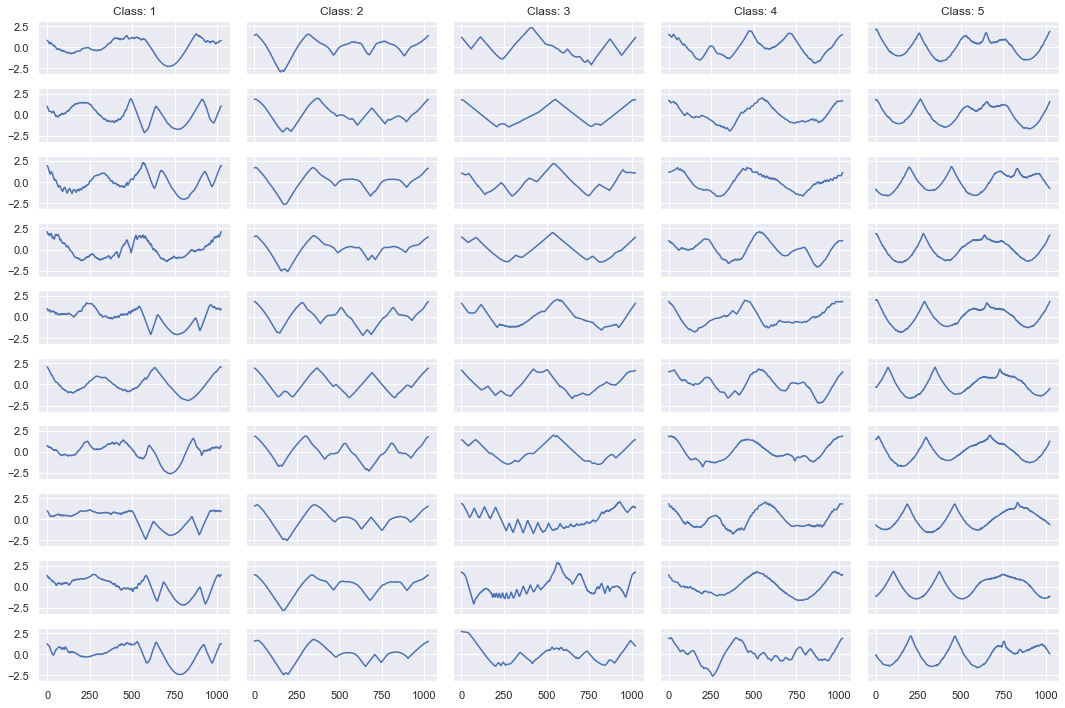

In [15]:
if PLOT:
    rolling_dataset = pd.concat([labels, features.rolling(SMOOTHING_WINDOW, axis=1).mean()], axis=1)
    rolling_dataset = rolling_dataset.dropna(axis=1)
    rolling_samples = visualize_dataset(rolling_dataset, NUM_SAMPLES_PER_CLASS)

## Data Cleaning

In [16]:
# any dupplicates?
features.duplicated().any()

False

**Conclusion: No**

In [17]:
# any missing values?
features.isna().sum().sum()

0

**Conclusion: No**

In [18]:
# Low pass filtering
features = features.rolling(SMOOTHING_WINDOW, axis=1).mean()
features = features.dropna(axis=1)
    
features.shape

(499, 1024)

In [19]:
# downsampling
features = features[features.columns[::DOWNSAMPLE_WINDOW]]

features.shape

(499, 1024)

Samples shape: (50, 1024)


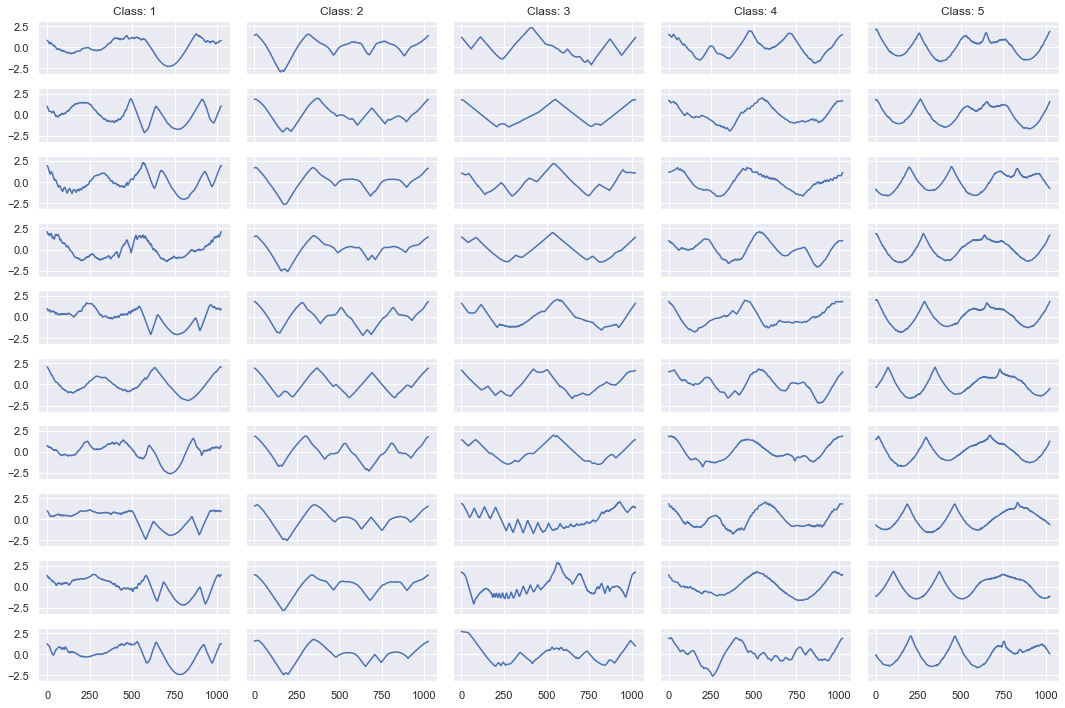

In [20]:
if PLOT:
    samples = visualize_dataset(pd.concat([labels, features], axis=1), NUM_SAMPLES_PER_CLASS)

# Preprocessing

**Conclusion: all sequences have the same length, therefore there is no need for special care in this aspect**

In [21]:
#label encoding
# no need for a LabelEncoder(), just substruct 1 from the labels to have it 0-based.
labels["1"] = labels["1"].apply(lambda x: x-1)

d:\raz\projects\owlytics\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Modeling

## Experiment #1: KNN with DTW


## Testing the DTW metric

In [22]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
# from fastdtw import fastdtw
# from scipy.spatial.distance import euclidean

In [34]:
class_names = labels["1"].unique()

# dists = [ [ None ]*len(class_names) ]*len(class_names)

# for i in range(len(class_names)):

#     for j in range(i, len(class_names)):
#         cls_x = X_train.loc[y_train["1"]==class_names[i]]
#         cls_y = X_train.loc[y_train["1"]==class_names[j]]
#         dists[i][j] = [dtw.distance_fast(cls_x.iloc[x].values, cls_y.iloc[y].values, window=100) for x in range(5) for y in range(5)]



In [37]:
# fig, axes = plt.subplots(len(class_names), len(class_names), figsize=(15,10), sharey=True)

# for i in range(len(dists)):
#     for j in range(i, len(dists)):
#         sns.distplot(dists[j][i], ax=axes[j][i])
#         if i==0:
#             axes[i][j].set_title(f"Class: {class_names[j]}")
    

# plt.tight_layout()

In [38]:
cls1 = features.loc[labels["1"]==2]
cls2 = features.loc[labels["1"]==2]

dists_same_cls = np.zeros((len(cls1),len(cls1)))
for i in tqdm(range(len(cls1))):
    for j in range(len(cls2)):
        s1 = cls1.iloc[i].values
        s2 = cls2.iloc[j].values
        dists_same_cls[i,j] = dtw.distance_fast(s1, s2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


In [39]:
cls1 = features.loc[labels["1"]==2]
cls2 = features.loc[labels["1"]==3]

dists_diff_cls = np.zeros((len(cls1),len(cls1)))
for i in tqdm(range(len(cls1))):
    for j in range(len(cls2)):
        s1 = cls1.iloc[i].values
        s2 = cls2.iloc[j].values
        dists_diff_cls[i,j] = dtw.distance_fast(s1, s2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Text(0.5, 1.0, 'Different class dtw distance')

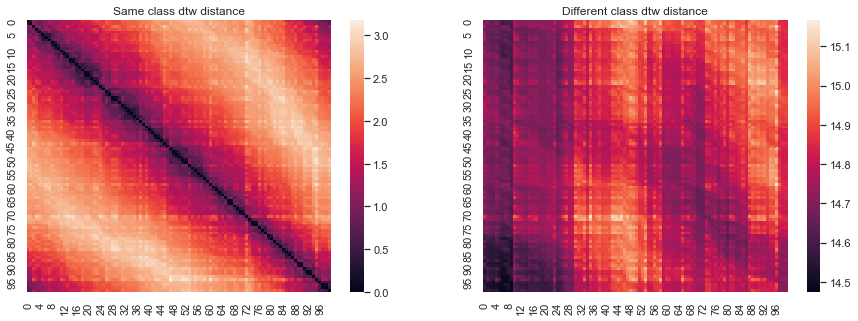

In [40]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(dists_same_cls, ax=axes[0])
sns.heatmap(dists_diff_cls, ax=axes[1])
axes[0].set_title("Same class dtw distance")
axes[1].set_title("Different class dtw distance")

In [41]:
X = features
y = labels["1"]
best_model = {
    "mean_score":0,
    "model":None
}
Kfolds = 5

skf = StratifiedKFold(n_splits=Kfolds)

for n_neighbors in [1, 3, 5]:
    for window in [20, 40, 60, 80, 100]:
        for weight in ["uniform"]:#, "distance"]:
#             cls = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weight, metric=dtw.distance_fast, metric_params={"window": window})
            cls = KNeighborsClassifier(n_neighbors=n_neighbors)
            print(cls)

            scores = []    
            for k, (train_index, val_index) in enumerate(skf.split(X, y)):
                cls.fit(X.loc[train_index], y.loc[train_index])
                y_pred = cls.predict(X.loc[val_index])
                score = f1_score(y.loc[val_index], y_pred, average="macro")
                print(f"K: {k} Score: {score:.3f}")
                scores.append(score)
            
#             print(scores)
            mean_score = np.mean(scores)    
            print(f"Mean F1-score macro average: {mean_score:.3f}")
            print()
            
            if mean_score > best_model["mean_score"]:
                best_model["mean_score"]=mean_score
                best_model["model"]=cls

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
K: 0 Score: 0.899
K: 1 Score: 0.899
K: 2 Score: 0.871
K: 3 Score: 0.910
K: 4 Score: 0.899
Mean F1-score macro average: 0.896

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
K: 0 Score: 0.899
K: 1 Score: 0.899
K: 2 Score: 0.871
K: 3 Score: 0.910
K: 4 Score: 0.899
Mean F1-score macro average: 0.896

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
K: 0 Score: 0.899
K: 1 Score: 0.899
K: 2 Score: 0.871
K: 3 Score: 0.910
K: 4 Score: 0.899
Mean F1-score macro average: 0.896

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='

In [42]:
best_model

{'mean_score': 0.8956157539602028,
 'model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                      weights='uniform')}

In [43]:
# grid_params = {
#     "n_neighbors": [1,3,5,7,9],
#     "weights": ["uniform", "distance"],
#     "metric": [dtw.distance_fast, "minkowski"]
# }

# knn_gs = GridSearchCV(
#     KNeighborsClassifier(),
#     grid_params,
#     verbose=1,
#     cv=5,
#     n_jobs=-1,
# )

In [44]:
# knn_gs_results = gs.fit(features, labels["1"])

In [45]:
# print("best_score: ", knn_gs_results.best_score_)
# print("best_estimator_: ", knn_gs_results.best_estimator_)
# print("best_params_: ", knn_gs_results.best_params_)

## Experiment #2: Feature extraction with DWT + classic ML classifier

In [46]:
import pywt

In [47]:
# CWT + CNN
# scales = np.arange(1,128)
# waveletname = 'mexh'
# sample = features.iloc[400]
# time = np.arange(len(sample.index))
# signal = sample.values
# plot_wavelet(time, signal, scales, waveletname=waveletname)

In [48]:
DECOMPOSITION_LEVEL = 3

coeffs = pywt.wavedec(features.iloc[0], 'db2', level=DECOMPOSITION_LEVEL)
nth_level_approx_coeffs = coeffs[0]
nth_level_approx_coeffs.shape

(130,)

In [49]:
best_model = {
    "mean_score":0,
    "model":None,
    "decomp_level":0,
    "wavelet":"",
}
Kfolds = 5

skf = StratifiedKFold(n_splits=Kfolds)

for decomp_level in [1, 2, 3, 4, 5, 6]:
    for wavelet in ['db2', "coif2", "sym2", "haar"]:
        cwt_features = []
        for i, row in features.iterrows():
            coeffs = pywt.wavedec(row, wavelet, level=decomp_level)
            nth_level_approx_coeffs = coeffs[0]
            cwt_features.append(nth_level_approx_coeffs)

        X = pd.DataFrame(cwt_features, index=features.index)

        for max_depth in range(2,32,2):

            for n_estimators in [50, 100, 150]:
                cls = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
                print(cls)

                scores = []    
                for k, (train_index, val_index) in enumerate(skf.split(X, y)):
                    cls.fit(X.loc[train_index], y.loc[train_index])
                    y_pred = cls.predict(X.loc[val_index])
                    score = f1_score(y.loc[val_index], y_pred, average="macro")
                    print(f"K: {k} Level: {decomp_level} Score: {score:.3f}")
                    scores.append(score)

    #             print(scores)
                mean_score = np.mean(scores)    
                print(f"Mean F1-score macro average: {mean_score:.3f}")
                print()

                if mean_score > best_model["mean_score"]:
                    best_model["mean_score"]=mean_score
                    best_model["model"]=cls
                    best_model["decomp_level"]=decomp_level
                    best_model["wavelet"]=wavelet

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.680
K: 1 Level: 1 Score: 0.637
K: 2 Level: 1 Score: 0.653
K: 3 Level: 1 Score: 0.648
K: 4 Level: 1 Score: 0.676
Mean F1-score macro average: 0.659

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
 

K: 0 Level: 1 Score: 0.899
K: 1 Level: 1 Score: 0.866
K: 2 Level: 1 Score: 0.881
K: 3 Level: 1 Score: 0.856
K: 4 Level: 1 Score: 0.857
Mean F1-score macro average: 0.872

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.899
K: 1 Level: 1 Score: 0.844
K: 2 Level: 1 Score: 0.870
K: 3 Level: 1 Score: 0.888
K: 4 Level: 1 Score: 0.888
Mean F1-score macro average: 0.878

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.879
K: 1 Level: 1 Score: 0.860
K: 2 Level: 1 Score: 0.849
K: 3 Level: 1 Score: 0.877
K: 4 Level: 1 Score: 0.868
Mean F1-score macro average: 0.867

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.869
K: 1 Level: 1 Score: 0.850
K: 2 Level: 1 Score: 0.859
K: 3 Level: 1 Score: 0.864
K: 4 Level: 1 Score: 0.858
Mean F1-score macro average: 0.860

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.890
K: 1 Level: 1 Score: 0.858
K: 2 Level: 1 Score: 0.870
K: 3 Level: 1 Score: 0.864
K: 4 Level: 1 Score: 0.868
Mean F1-score macro average: 0.870

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.909
K: 1 Level: 1 Score: 0.866
K: 2 Level: 1 Score: 0.861
K: 3 Level: 1 Score: 0.877
K: 4 Level: 1 Score: 0.866
Mean F1-score macro average: 0.876

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.680
K: 1 Level: 1 Score: 0.665
K: 2 Level: 1 Score: 0.653
K: 3 Level: 1 Score: 0.681
K: 4 Level: 1 Score: 0.652
Mean F1-score macro average: 0.666

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.831
K: 1 Level: 1 Score: 0.779
K: 2 Level: 1 Score: 0.849
K: 3 Level: 1 Score: 0.840
K: 4 Level: 1 Score: 0.817
Mean F1-score macro average: 0.823

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', m

K: 0 Level: 1 Score: 0.909
K: 1 Level: 1 Score: 0.897
K: 2 Level: 1 Score: 0.860
K: 3 Level: 1 Score: 0.876
K: 4 Level: 1 Score: 0.868
Mean F1-score macro average: 0.882

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.908
K: 1 Level: 1 Score: 0.838
K: 2 Level: 1 Score: 0.859
K: 3 Level: 1 Score: 0.879
K: 4 Level: 1 Score: 0.847
Mean F1-score macro average: 0.866

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.870
K: 2 Level: 1 Score: 0.849
K: 3 Level: 1 Score: 0.865
K: 4 Level: 1 Score: 0.878
Mean F1-score macro average: 0.870

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.899
K: 1 Level: 1 Score: 0.865
K: 2 Level: 1 Score: 0.879
K: 3 Level: 1 Score: 0.868
K: 4 Level: 1 Score: 0.888
Mean F1-score macro average: 0.880

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.898
K: 2 Level: 1 Score: 0.871
K: 3 Level: 1 Score: 0.854
K: 4 Level: 1 Score: 0.867
Mean F1-score macro average: 0.876

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=28, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.860
K: 1 Level: 1 Score: 0.879
K: 2 Level: 1 Score: 0.848
K: 3 Level: 1 Score: 0.874
K: 4 Level: 1 Score: 0.878
Mean F1-score macro average: 0.868

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.859
K: 1 Level: 1 Score: 0.796
K: 2 Level: 1 Score: 0.826
K: 3 Level: 1 Score: 0.853
K: 4 Level: 1 Score: 0.818
Mean F1-score macro average: 0.831

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.848
K: 1 Level: 1 Score: 0.857
K: 2 Level: 1 Score: 0.850
K: 3 Level: 1 Score: 0.835
K: 4 Level: 1 Score: 0.838
Mean F1-score macro average: 0.846

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', m

K: 0 Level: 1 Score: 0.898
K: 1 Level: 1 Score: 0.878
K: 2 Level: 1 Score: 0.860
K: 3 Level: 1 Score: 0.876
K: 4 Level: 1 Score: 0.868
Mean F1-score macro average: 0.876

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.919
K: 1 Level: 1 Score: 0.879
K: 2 Level: 1 Score: 0.880
K: 3 Level: 1 Score: 0.864
K: 4 Level: 1 Score: 0.867
Mean F1-score macro average: 0.882

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.860
K: 2 Level: 1 Score: 0.859
K: 3 Level: 1 Score: 0.885
K: 4 Level: 1 Score: 0.838
Mean F1-score macro average: 0.866

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.891
K: 1 Level: 1 Score: 0.879
K: 2 Level: 1 Score: 0.849
K: 3 Level: 1 Score: 0.886
K: 4 Level: 1 Score: 0.849
Mean F1-score macro average: 0.871

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.899
K: 1 Level: 1 Score: 0.878
K: 2 Level: 1 Score: 0.839
K: 3 Level: 1 Score: 0.877
K: 4 Level: 1 Score: 0.888
Mean F1-score macro average: 0.876

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.876
K: 2 Level: 1 Score: 0.870
K: 3 Level: 1 Score: 0.876
K: 4 Level: 1 Score: 0.835
Mean F1-score macro average: 0.869

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

K: 0 Level: 1 Score: 0.890
K: 1 Level: 1 Score: 0.867
K: 2 Level: 1 Score: 0.848
K: 3 Level: 1 Score: 0.875
K: 4 Level: 1 Score: 0.847
Mean F1-score macro average: 0.865

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.909
K: 1 Level: 1 Score: 0.853
K: 2 Level: 1 Score: 0.839
K: 3 Level: 1 Score: 0.858
K: 4 Level: 1 Score: 0.868
Mean F1-score macro average: 0.866

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', m

K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.879
K: 2 Level: 1 Score: 0.870
K: 3 Level: 1 Score: 0.885
K: 4 Level: 1 Score: 0.877
Mean F1-score macro average: 0.880

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
K: 0 Level: 1 Score: 0.889
K: 1 Level: 1 Score: 0.846
K: 2 Level: 1 Score: 0.849
K: 3 Level: 1 Score: 0.852
K: 4 Level: 1 Score: 0.879
Mean F1-score macro average: 0.863

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

KeyboardInterrupt: 

In [50]:
best_model

{'mean_score': 0.8901927056576129,
 'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=26, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=150,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'decomp_level': 1,
 'wavelet': 'db2'}

In [ ]:
# grid_params = {
#     "max_depth": list(range(2,32,2)),
# }

# rf_gs = GridSearchCV(
#     RandomForestClassifier(),
#     grid_params,
#     verbose=1,
#     cv=5,
#     n_jobs=-1,
# )

In [ ]:
# rf_gs_results = rf_gs.fit(cwt_features, labels["1"])

In [ ]:
# print("best_score: ", rf_gs_results.best_score_)
# print("best_estimator_: ", rf_gs_results.best_estimator_)
# print("best_params_: ", rf_gs_results.best_params_)

In [51]:
cwt_features_scaled = preprocessing.scale(cwt_features)
# cwt_features_scaled = cwt_features - cwt_features.mean()


In [52]:
pca = PCA(n_components=2)
pca.fit(cwt_features_scaled)
X = pca.transform(cwt_features_scaled)

In [53]:
cls1 = X[np.where(labels["1"]==1)[0]]
cls2 = X[np.where(labels["1"]==2)[0]]
cls3 = X[np.where(labels["1"]==3)[0]]
cls4 = X[np.where(labels["1"]==4)[0]]
cls5 = X[np.where(labels["1"]==5)[0]]

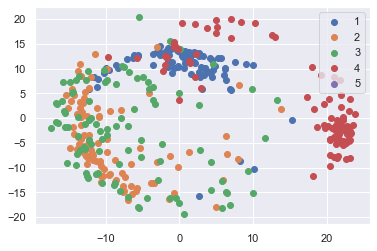

In [54]:
plt.scatter(cls1[:, 0], cls1[:, 1], label=1)
plt.scatter(cls2[:, 0], cls2[:, 1], label=2)
plt.scatter(cls3[:, 0], cls3[:, 1], label=3)
plt.scatter(cls4[:, 0], cls4[:, 1], label=4)
plt.scatter(cls5[:, 0], cls5[:, 1], label=5)
plt.legend()

## Experiment #3: Deep LSTM + FC classifier

In [55]:
from multiprocessing import cpu_count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from deep_ts import LSTMClassifier, Trainer

from utils import *

torch.manual_seed(1)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device}")

Using cpu


In [63]:
print('Preparing datasets')

trn_ds_list, val_ds_list = create_datasets(features, y.values, cv=5)

batch_size = features.shape[0]
print(f'Creating data loaders with batch size: {batch_size}')
data_loaders = [create_loaders(trn_ds, val_ds, batch_size) for trn_ds, val_ds in zip(trn_ds_list, val_ds_list)]

Preparing datasets
Creating data loaders with batch size: 499


In [64]:
best_model = {
    "mean_score":0,
    "model":None
}

for layer_dim in [1,2,3,4,5]:
    for hidden_dim in [16, 32, 64, 128, 256, 512]:
        
        scores = []
        for k, (trn_dl, val_dl) in enumerate(data_loaders):

            input_dim = features.shape[1]
            output_dim = 5

            n_epochs = 1000
            patience = 100
            lr = 0.0005
            iterations_per_epoch = len(trn_dl)

            model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim, device)
            model = model.to(device)
            criterion = nn.CrossEntropyLoss()
            opt = torch.optim.RMSprop(model.parameters(), lr=lr)
            sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

            best_score = Trainer(model, trn_dl, val_dl, n_epochs, sched, opt, criterion, device, patience)
            scores.append(best_score)
        
        print(scores)
        mean_score = np.mean(scores)    
        print(f"Mean F1-score macro average: {mean_score:.3f}")
        print()
        
        if mean_score > best_model["mean_score"]:
            best_model["mean_score"]=mean_score
            best_model["model"]=cls


Start model training
LSTMClassifier(
  (rnn): LSTM(1024, 16, batch_first=True)
  (fc_out): Linear(in_features=16, out_features=5, bias=True)
)
Epoch 1 best model saved with f1_score: 28.64%
Epoch 2 best model saved with f1_score: 39.02%
Epoch 3 best model saved with f1_score: 47.73%
Epoch 4 best model saved with f1_score: 48.17%
Epoch 5 best model saved with f1_score: 55.35%
Epoch 6 best model saved with f1_score: 61.71%
Epoch 7 best model saved with f1_score: 63.87%
Epoch 8 best model saved with f1_score: 65.08%
Epoch 9 best model saved with f1_score: 67.58%
Epoch:  10. Loss: 1.1950. F1 score: 69.35%, Acc.: 71.00%
Epoch 10 best model saved with f1_score: 69.35%
Epoch 11 best model saved with f1_score: 71.51%
Epoch 12 best model saved with f1_score: 72.64%
Epoch 14 best model saved with f1_score: 74.70%
Epoch:  20. Loss: 1.0403. F1 score: 73.30%, Acc.: 75.00%
Epoch 21 best model saved with f1_score: 75.67%
Epoch 23 best model saved with f1_score: 76.50%
Epoch 25 best model saved with f

KeyboardInterrupt: 

In [65]:
best_model

{'mean_score': 0, 'model': None}